# Description
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death. In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today. Every week from late spring through the fall, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations. The goal of this competition is to be able to predict when and where different species of mosquitoes will test positive for West Nile virus, based on location, spraying and testing data.

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import csv

In [43]:
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',1000)

spray_df = pd.read_csv("src/spray.csv")
sampleSubmission_df = pd.read_csv("src/sampleSubmission.csv")
train_df = pd.read_csv("src/train.csv")
test_df = pd.read_csv("src/test.csv")
weather_df = pd.read_csv("src/weather.csv")

In [44]:
spray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [45]:
sampleSubmission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Id          116293 non-null  int64
 1   WnvPresent  116293 non-null  int64
dtypes: int64(2)
memory usage: 1.8 MB


In [46]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [47]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


### Train and Test datasets

| Field                  | Description                                                                                           |
|------------------------|-------------------------------------------------------------------------------------------------------|
| Id                     | The ID of the record                                                                                  |
| Date                   | Date that the WNV test is performed                                                                   |
| Address                | Approximate address of the location of the trap. This is used to send to the GeoCoder                 |
| Species                | The species of mosquitoes                                                                             |
| Block                  | Block number of the address                                                                           |
| Street                 | Street name                                                                                           |
| Trap                   | ID of the trap                                                                                        |
| AddressNumberAndStreet | Approximate address returned from GeoCoder                                                            |
| Latitude               | Latitude returned from GeoCoder                                                                       |
| Longitude              | Longitude returned from GeoCoder                                                                      |
| AddressAccuracy        | Accuracy returned from GeoCoder                                                                       |
| NumMosquitos           | Number of mosquitoes caught in this trap                                                              |
| WnvPresent             | Whether West Nile Virus was present in these mosquitoes. 1 means WNV is present, and 0 means not present |

### Spray dataset

| Field          | Description                                                   |
|----------------|---------------------------------------------------------------|
| Date           | The date of the spray                                         |
| Time           | The time of the spray                                         |
| Latitude       | The Latitude of the spray location                            |
| Longitude      | The Longitude of the spray location                           |

### Weather dataset

| Field         | Description                                                                                   |
|---------------|-----------------------------------------------------------------------------------------------|
| Station       | The station identifier                                                                        |
| Date          | The date of the observation                                                                   |
| Tmax          | Maximum temperature recorded on that day (in degrees Fahrenheit)                              |
| Tmin          | Minimum temperature recorded on that day (in degrees Fahrenheit)                              |
| Tavg          | Average temperature of the day (in degrees Fahrenheit)                                        |
| Depart        | Departure of the average temperature from normal values                                       |
| DewPoint      | The average dew point temperature for the day (in degrees Fahrenheit)                         |
| WetBulb       | The average wet bulb temperature for the day (in degrees Fahrenheit)                          |
| Heat          | Heating degree days (base 65°F)                                                               |
| Cool          | Cooling degree days (base 65°F)                                                               |
| Sunrise       | Time of sunrise (calculated, not observed)                                                    |
| Sunset        | Time of sunset (calculated, not observed)                                                     |
| CodeSum       | Significant weather types (coded as combinations of weather phenomena)                        |
| Depth         | Depth of snow/ice on the ground at 12:00 UTC (in inches)                                      |
| Water1        | Water equivalent of snow/ice at 18:00 UTC (in inches)                                         |
| PrecipTotal   | Total precipitation for the day (in inches)                                                   |
| StnPressure   | Average station pressure for the day (in inches of mercury)                                   |
| SeaLevel      | Average sea level pressure for the day (in inches of mercury)                                 |
| ResultSpeed   | Resultant wind speed (in miles per hour)                                                      |
| ResultDir     | Resultant wind direction (in whole degrees)                                                   |
| AvgSpeed      | Average wind speed for the day (in miles per hour)                                            |

In [49]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [50]:
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [51]:
spray_df.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


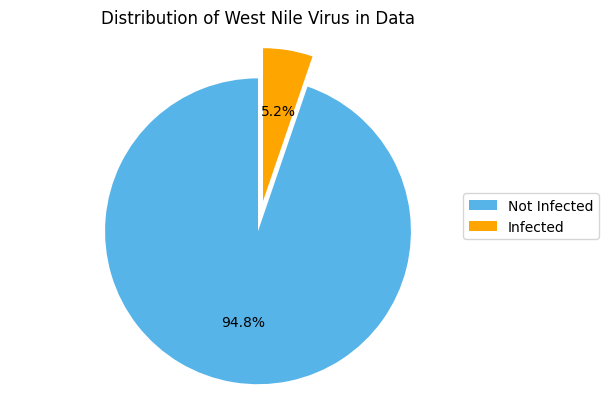

In [52]:
is_infected = train_df["WnvPresent"].value_counts()

labels = 'Not Infected', 'Infected'
sizes = [is_infected[0], is_infected[1]]  
colors = ['#56B4E9', '#FFA500']
explode = (0.1, 0.1)  

fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal') 
plt.title('Distribution of West Nile Virus in Data')
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.show()

We can see that our training dataset is highly imbalanced. We need use resampling techniques to handle this.

In [56]:
def date(text):
    return datetime.datetime.strptime(text, "%Y-%m-%d").date()

the **date** function converts a string representing a date into a Python date object which can then be used for operations requiring date manipulation

In [55]:
def precip(text):
    TRACE = 1e-3
    text = text.strip()
    if text == "M":
        return None
    if text == "-":
        return None
    if text == "T":
        return TRACE
    return float(text)

the **precip** function allows you to process textual data representing precipitation, typically used in meteorological datasets


In [54]:
def impute_missing_weather_station_values(weather):
    for k, v in weather.items():
        if v[0] is None:
            v[0] = v[1]
        elif v[1] is None:
            v[1] = v[0]
        for k1 in v[0]:
            if v[0][k1] is None:
                v[0][k1] = v[1][k1]
        for k1 in v[1]:
            if v[1][k1] is None:
                v[1][k1] = v[0][k1]

In [57]:
species_map = {
    'CULEX RESTUANS' : "100000",
    'CULEX TERRITANS' : "010000", 
    'CULEX PIPIENS'   : "001000", 
    'CULEX PIPIENS/RESTUANS' : "101000", 
    'CULEX ERRATICUS' : "000100", 
    'CULEX SALINARIUS': "000010", 
    'CULEX TARSALIS' :  "000001",
    'UNSPECIFIED CULEX': "001000"
}

In [60]:
def closest_station(lat, longi):
    stations = np.array([[41.995, -87.933],
                         [41.786, -87.752]])
    loc = np.array([lat, longi])
    deltas = stations - loc[None, :]
    dist2 = (deltas**2).sum(1)
    return np.argmin(dist2)

In [61]:
def standardize(X, mean=None, std=None):
    count = X.shape[1]
    if mean is None:
        mean = np.nanmean(X, axis=0)
    for i in range(count):
        X[np.isnan(X[:,i]), i] = mean[i]
    if std is None:
        std = np.std(X, axis=0)
    for i in range(count):
        X[:,i] = (X[:,i] - mean[i]) / std[i]
    return mean, std

In [62]:
def scaled_count(record):
    SCALE = 9.0
    if "NumMosquitos" not in record: # For test data
        return 1
    return int(np.ceil(record["NumMosquitos"] / SCALE))

In [ ]:
WEATHER_CONVERT = {
    "Date" : date,
    "Tmax" : float,
    "Tmin" : float,
    "Tavg" : float,
    "DewPoint" : float, 
    "WetBulb" : float,
    "PrecipTotal" : precip,
    "Sunrise" : precip,
    "Sunset" : precip,
    "Depart" : float, 
    "Heat" : precip,
    "Cool" : precip,
    "ResultSpeed" : float,
    "ResultDir" : float,
    "AvgSpeed" : float,
    "StnPressure" : float, 
    "SeaLevel" : float
}

weather = {}
for line in csv.DictReader(open("weather.csv")):
    for name, converter in WEATHER_CONVERT.items():
        x = line[name].strip()
        line[name] = converter(x) if (x != "M") else None
    station = int(line["Station"]) - 1
    assert station in [0,1]
    dt = line["Date"]
    if dt not in weather:
        weather[dt] = [None, None]
    assert weather[dt][station] is None, "duplicate weather reading {0}:{1}".format(dt, station)
    weather[dt][station] = line
impute_missing_weather_station_values(weather)

In [ ]:
TRAINING_CONVERT = {
    "Date" : date, 
    "Latitude" : float, 
    "Longitude" : float,
    "NumMosquitos" : int, 
    "WnvPresent" : int
}

training = []
for line in csv.DictReader(open("train.csv")):
    for name, converter in TRAINING_CONVERT.items():
        line[name] = converter(line[name])
    training.append(line)

In [ ]:
TESTING_CONVERT = {
    "Date" : date, 
    "Latitude" : float, 
    "Longitude" : float
}

testing = []
for line in csv.DictReader(open("test.csv")):
    for name, converter in TESTING_CONVERT.items():
        line[name] = converter(line[name])
    testing.append(line)

In [ ]:
LOOKBACK = 10
WEATHER_FEATURES = ["Tmax","Tmin","Tavg","DewPoint","WetBulb","PrecipTotal","Depart","Sunrise","Sunset","Cool","ResultSpeed","ResultDir"]
USE_SCALED_COUNT = False
DATA_FACTOR = int(fv[0]/fv[1])
USE_DATA_FACTOR = True

In [ ]:
def get_X(base, weather):
    X = []
    
    for b in base:
        date = b["Date"]
        lat, longi = b["Latitude"], b["Longitude"]
        case = [date.year, date.month, date.day, date.weekday(), lat, longi]
        station = closest_station(lat, longi)
        
        for days_ago in range(LOOKBACK+1):
            day = date - datetime.timedelta(days=days_ago)
            for obs in WEATHER_FEATURES:
                case.append(weather[day][station][obs])
        
        species_vector = [float(x) for x in species_map[b["Species"]]]
        case.extend(species_vector)
        
        if USE_DATA_FACTOR and "WnvPresent" in b and b["WnvPresent"]==1: 
            for _ in range(DATA_FACTOR):
                X.append(case)
        elif USE_SCALED_COUNT :
            for repeat in range(scaled_count(b)):
                X.append(case)
        else : 
            X.append(case)
    X = np.asarray(X, dtype=np.float32)
    return X
    
def get_Y(base):
    y = []
    for b in base:
        present = b["WnvPresent"]
        if USE_DATA_FACTOR and "WnvPresent" in b and b["WnvPresent"]==1: 
            for _ in range(DATA_FACTOR):
                y.append(present)
        elif USE_SCALED_COUNT : 
            for repeat in range(scaled_count(b)):
                y.append(present)    
        else : 
            y.append(present)
    return np.asarray(y, dtype=np.int32).reshape(-1,1)

In [ ]:
X = get_X(training, weather)
Y = get_Y(training)